In [124]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Hyperparameter, Kernel, WhiteKernel


# Kernel definition

In [113]:
kernel = 1.0 * RBF(
    length_scale=np.sqrt(1 / 4), length_scale_bounds="fixed"
) + WhiteKernel(noise_level=1.01, noise_level_bounds="fixed")

In [114]:
# load and normalize Mauna Loa data
data = np.genfromtxt("./data/co2_mm_mlo.csv", delimiter=",")

In [115]:
# 10 years of data for learning
X = data[:120, 2] - 1958
X = X.reshape(-1, 1)
y_raw = data[:120, 3]
y_mean = np.mean(y_raw)
y_std = np.sqrt(np.var(y_raw))
y = (y_raw - y_mean) / y_std
# the next 5 years for prediction
X_predict = data[120:180, 2] - 1958
X_predict = X_predict.reshape(-1, 1)
y_predict = data[120:180, 3]

In [118]:
gpc = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X, y)
gpc.kernel_

0.612**2 * RBF(length_scale=0.5) + WhiteKernel(noise_level=1.01)

In [119]:
gpc.kernel

1**2 * RBF(length_scale=0.5) + WhiteKernel(noise_level=1.01)

In [120]:
prediction_mean_gp, var_gp = gpc.predict(X_predict, return_std=True)

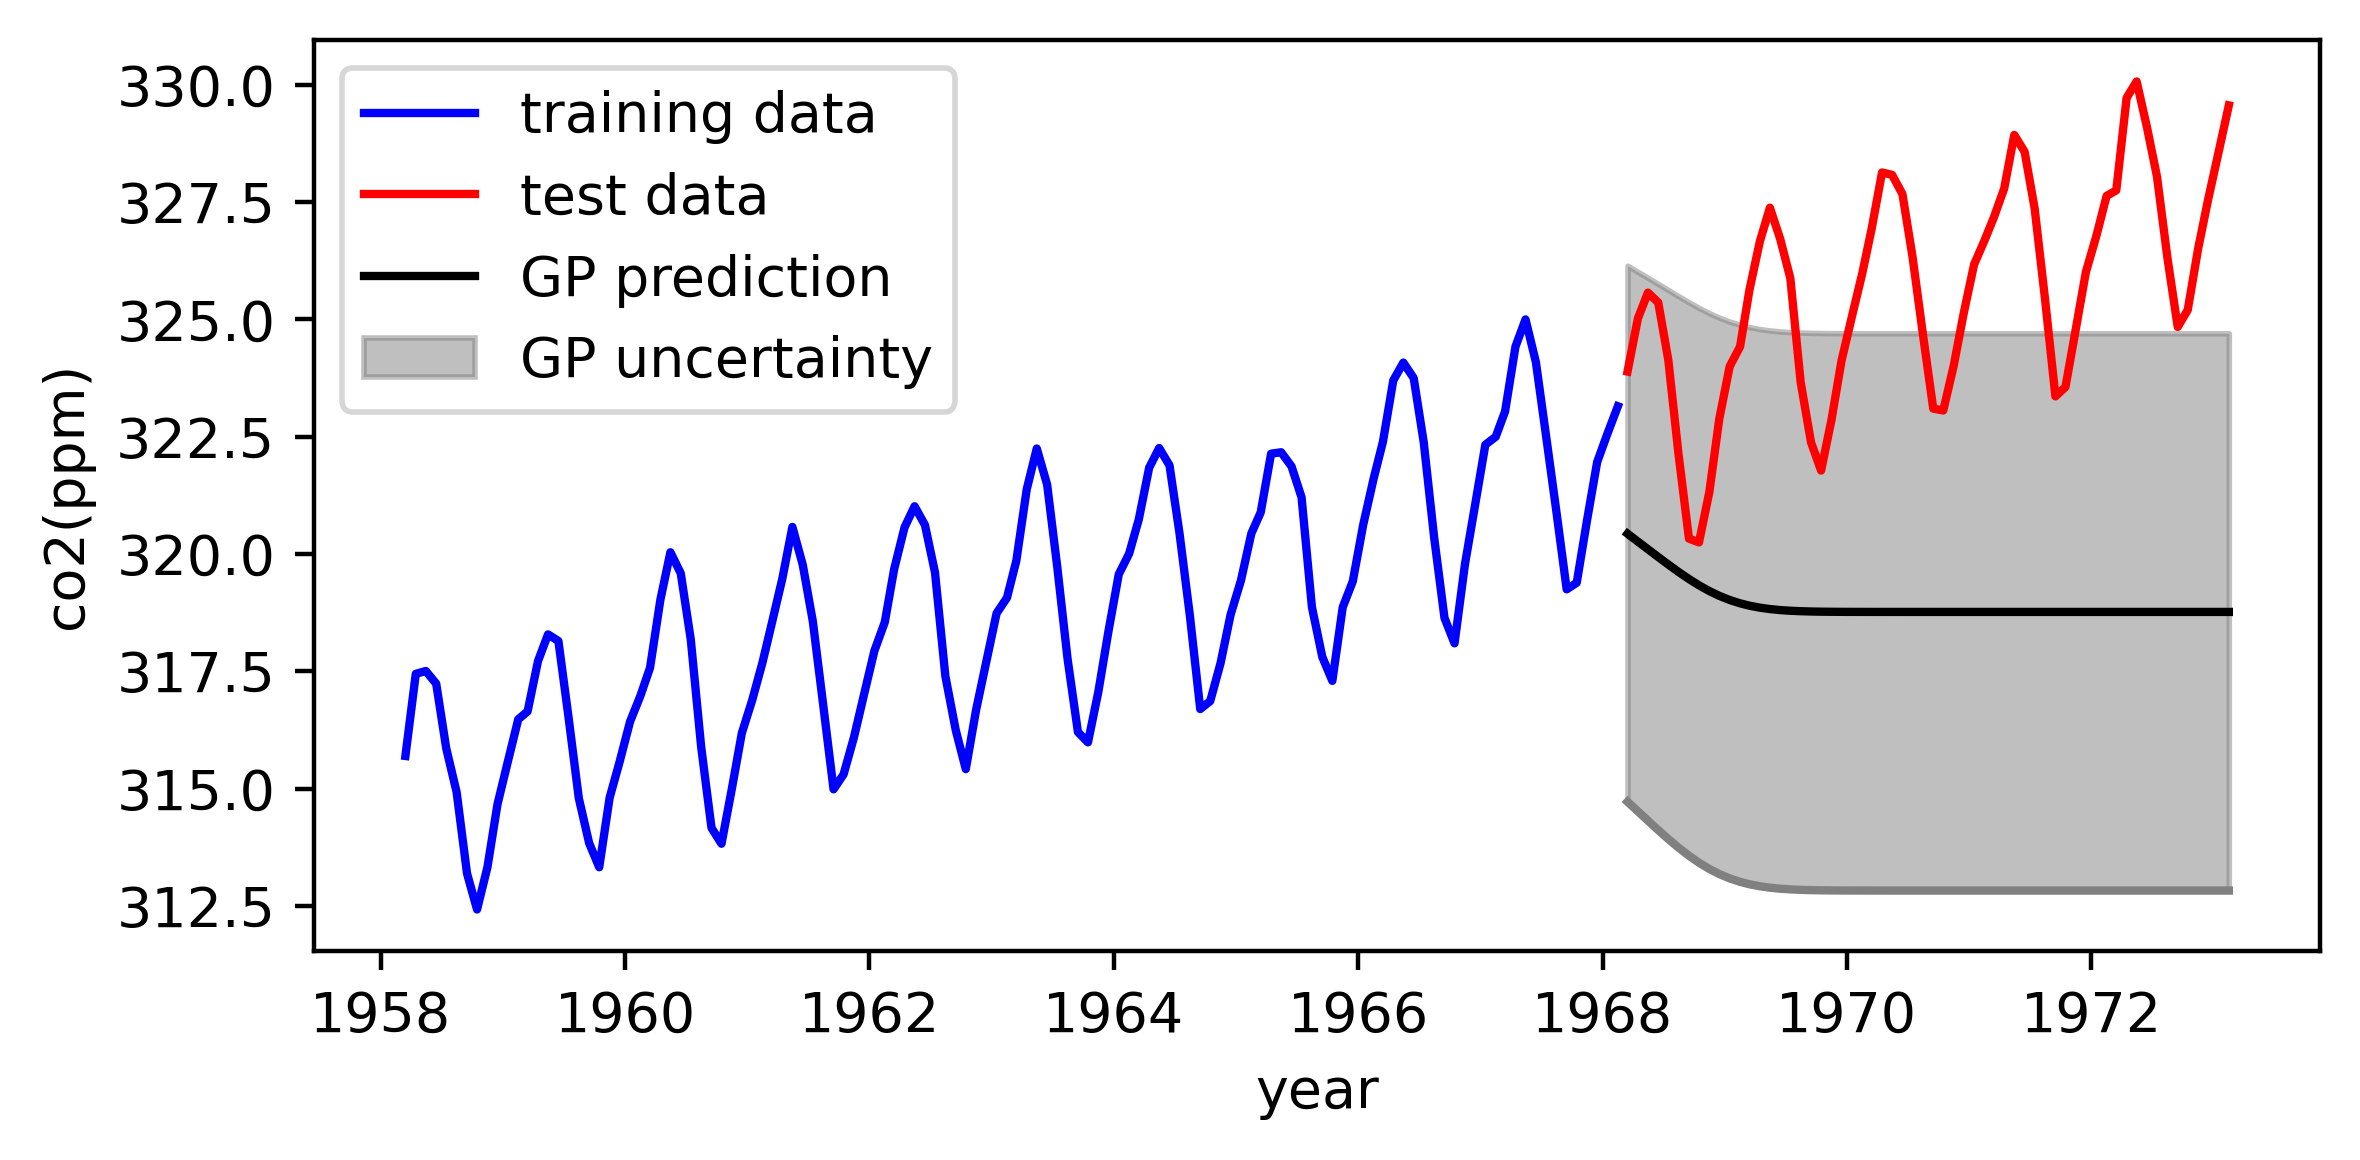

In [123]:
# plotting code for your convenience
plt.figure(dpi=400, figsize=(6, 3))
plt.plot(X + 1958, y_raw, color="blue", label="training data")
plt.plot(X_predict + 1958, y_predict, color="red", label="test data")
yout_m = prediction_mean_gp * y_std + y_mean
yout_v = var_gp * y_std**2
plt.plot(X_predict + 1958, yout_m, color="black", label="GP prediction")
# plt.plot(
#     X_predict + 1958, yout_m + 1.96 * yout_v**0.5, color="grey", label="GP uncertainty"
# )
plt.plot(X_predict + 1958, yout_m - 1.96 * yout_v**0.5, color="grey")
plt.fill_between(
    X_predict.reshape(-1) + 1958,
    yout_m - 1.96 * np.sqrt(yout_v),
    yout_m + 1.96 * np.sqrt(yout_v),
    color="grey",
    alpha=0.5,
    label="GP uncertainty",
)
plt.xlabel("year")
plt.ylabel("co2(ppm)")
plt.legend()
plt.tight_layout()

In [125]:
class SpecialKernel(Kernel):
    """Custom kernel corresponding to the special_kernel function."""

    def __init__(self, a=1.0, b=1.0, a_bounds=(1e-5, 1e5), b_bounds=(1e-5, 1e5)):
        self.a = a
        self.b = b
        self.a_bounds = a_bounds
        self.b_bounds = b_bounds

        # Define hyperparameters for optimization
        self.hyperparameter_a = Hyperparameter("a", "numeric", self.a_bounds)
        self.hyperparameter_b = Hyperparameter("b", "numeric", self.b_bounds)

    def __call__(self, X, Y=None, eval_gradient=False):
        X = np.atleast_2d(X)
        if Y is None:
            Y = X
        else:
            Y = np.atleast_2d(Y)

        K = (1 + X @ Y.T) ** 2 + self.a * np.multiply.outer(
            np.sin(2 * np.pi * X.reshape(-1) + self.b),
            np.sin(2 * np.pi * Y.reshape(-1) + self.b),
        )

        if eval_gradient:
            K_gradient_a = np.multiply.outer(
                np.sin(2 * np.pi * X.reshape(-1) + self.b),
                np.sin(2 * np.pi * Y.reshape(-1) + self.b),
            )
            K_gradient_a = K_gradient_a[..., np.newaxis]

            sin_X_b = np.sin(2 * np.pi * X.reshape(-1) + self.b)
            sin_Y_b = np.sin(2 * np.pi * Y.reshape(-1) + self.b)
            cos_X_b = np.cos(2 * np.pi * X.reshape(-1) + self.b)
            cos_Y_b = np.cos(2 * np.pi * Y.reshape(-1) + self.b)

            K_gradient_b = self.a * (
                np.multiply.outer(cos_X_b, sin_Y_b)
                + np.multiply.outer(sin_X_b, cos_Y_b)
            )
            K_gradient_b = K_gradient_b[..., np.newaxis]

            K_gradient = np.concatenate((K_gradient_a, K_gradient_b), axis=2)
            return K, K_gradient
        else:
            return K

    def diag(self, X):
        X = np.atleast_2d(X)
        K_diag = (1 + np.sum(X * X, axis=1)) ** 2 + self.a * (
            np.sin(2 * np.pi * X.reshape(-1) + self.b) ** 2
        )
        return K_diag

    def is_stationary(self):
        return False

    def __repr__(self):
        return f"{self.__class__.__name__}(a={self.a}, b={self.b})"

    def get_params(self, deep=True):
        return {
            "a": self.a,
            "b": self.b,
            "a_bounds": self.a_bounds,
            "b_bounds": self.b_bounds,
        }

    def set_params(self, **params):
        if "a" in params:
            self.a = params["a"]
        if "b" in params:
            self.b = params["b"]
        if "a_bounds" in params:
            self.a_bounds = params["a_bounds"]
        if "b_bounds" in params:
            self.b_bounds = params["b_bounds"]
        return self

In [136]:
class SpecialKernel2(Kernel):
    """Custom kernel corresponding to the special_kernel function, with support for fixing hyperparameters."""

    def __init__(self, a=1.0, b=1.0, a_bounds=(1e-5, 1e5), b_bounds=(1e-5, 1e5)):
        self.a = a
        self.b = b
        self.a_bounds = a_bounds
        self.b_bounds = b_bounds

        # Define hyperparameters for optimization
        self.hyperparameter_a = Hyperparameter("a", "numeric", self.a_bounds)
        self.hyperparameter_b = Hyperparameter("b", "numeric", self.b_bounds)

    def __call__(self, X, Y=None, eval_gradient=False):
        X = np.atleast_2d(X)
        if Y is None:
            Y = X
        else:
            Y = np.atleast_2d(Y)

        K = (1 + X @ Y.T) ** 2 + self.a * np.multiply.outer(
            np.sin(2 * np.pi * X.reshape(-1) + self.b),
            np.sin(2 * np.pi * Y.reshape(-1) + self.b),
        )

        if eval_gradient:
            # Initialize an empty list for K_gradients
            K_gradients = []

            # Compute the gradient w.r.t a if it's not fixed
            if self.hyperparameter_a.fixed:
                pass  # Do not compute gradient for fixed hyperparameter
            else:
                K_gradient_a = np.multiply.outer(
                    np.sin(2 * np.pi * X.reshape(-1) + self.b),
                    np.sin(2 * np.pi * Y.reshape(-1) + self.b),
                )
                K_gradients.append(K_gradient_a[..., np.newaxis])

            # Compute the gradient w.r.t b if it's not fixed
            if self.hyperparameter_b.fixed:
                pass  # Do not compute gradient for fixed hyperparameter
            else:
                sin_X_b = np.sin(2 * np.pi * X.reshape(-1) + self.b)
                sin_Y_b = np.sin(2 * np.pi * Y.reshape(-1) + self.b)
                cos_X_b = np.cos(2 * np.pi * X.reshape(-1) + self.b)
                cos_Y_b = np.cos(2 * np.pi * Y.reshape(-1) + self.b)

                K_gradient_b = self.a * (
                    np.multiply.outer(cos_X_b, sin_Y_b)
                    + np.multiply.outer(sin_X_b, cos_Y_b)
                )
                K_gradients.append(K_gradient_b[..., np.newaxis])

            if K_gradients:
                K_gradient = np.concatenate(K_gradients, axis=2)
            else:
                # If no gradients are computed (all hyperparameters are fixed)
                K_gradient = np.zeros(K.shape + (0,))

            return K, K_gradient
        else:
            return K

    def diag(self, X):
        X = np.atleast_2d(X)
        K_diag = (1 + np.sum(X * X, axis=1)) ** 2 + self.a * (
            np.sin(2 * np.pi * X.reshape(-1) + self.b) ** 2
        )
        return K_diag

    def is_stationary(self):
        return False

    def __repr__(self):
        return f"{self.__class__.__name__}(a={self.a}, b={self.b})"

    def get_params(self, deep=True):
        return {
            "a": self.a,
            "b": self.b,
            "a_bounds": self.a_bounds,
            "b_bounds": self.b_bounds,
        }

    def set_params(self, **params):
        if "a" in params:
            self.a = params["a"]
        if "b" in params:
            self.b = params["b"]
        if "a_bounds" in params:
            self.a_bounds = params["a_bounds"]
            # Update hyperparameter definition
            self.hyperparameter_a = Hyperparameter("a", "numeric", self.a_bounds)
        if "b_bounds" in params:
            self.b_bounds = params["b_bounds"]
            # Update hyperparameter definition
            self.hyperparameter_b = Hyperparameter("b", "numeric", self.b_bounds)
        return self

In [137]:
kernel2 = SpecialKernel2(a=2.0, b=8.00) + WhiteKernel(noise_level=1.01)

In [138]:
gpc2 = GaussianProcessRegressor(kernel=kernel2, random_state=0).fit(X, y)
gpc2.kernel_

SpecialKernel2(a=1.9483262484337682, b=24.810366980743296) + WhiteKernel(noise_level=0.253)

In [139]:
prediction_mean_gp, var_gp = gpc2.predict(X_predict, return_std=True)

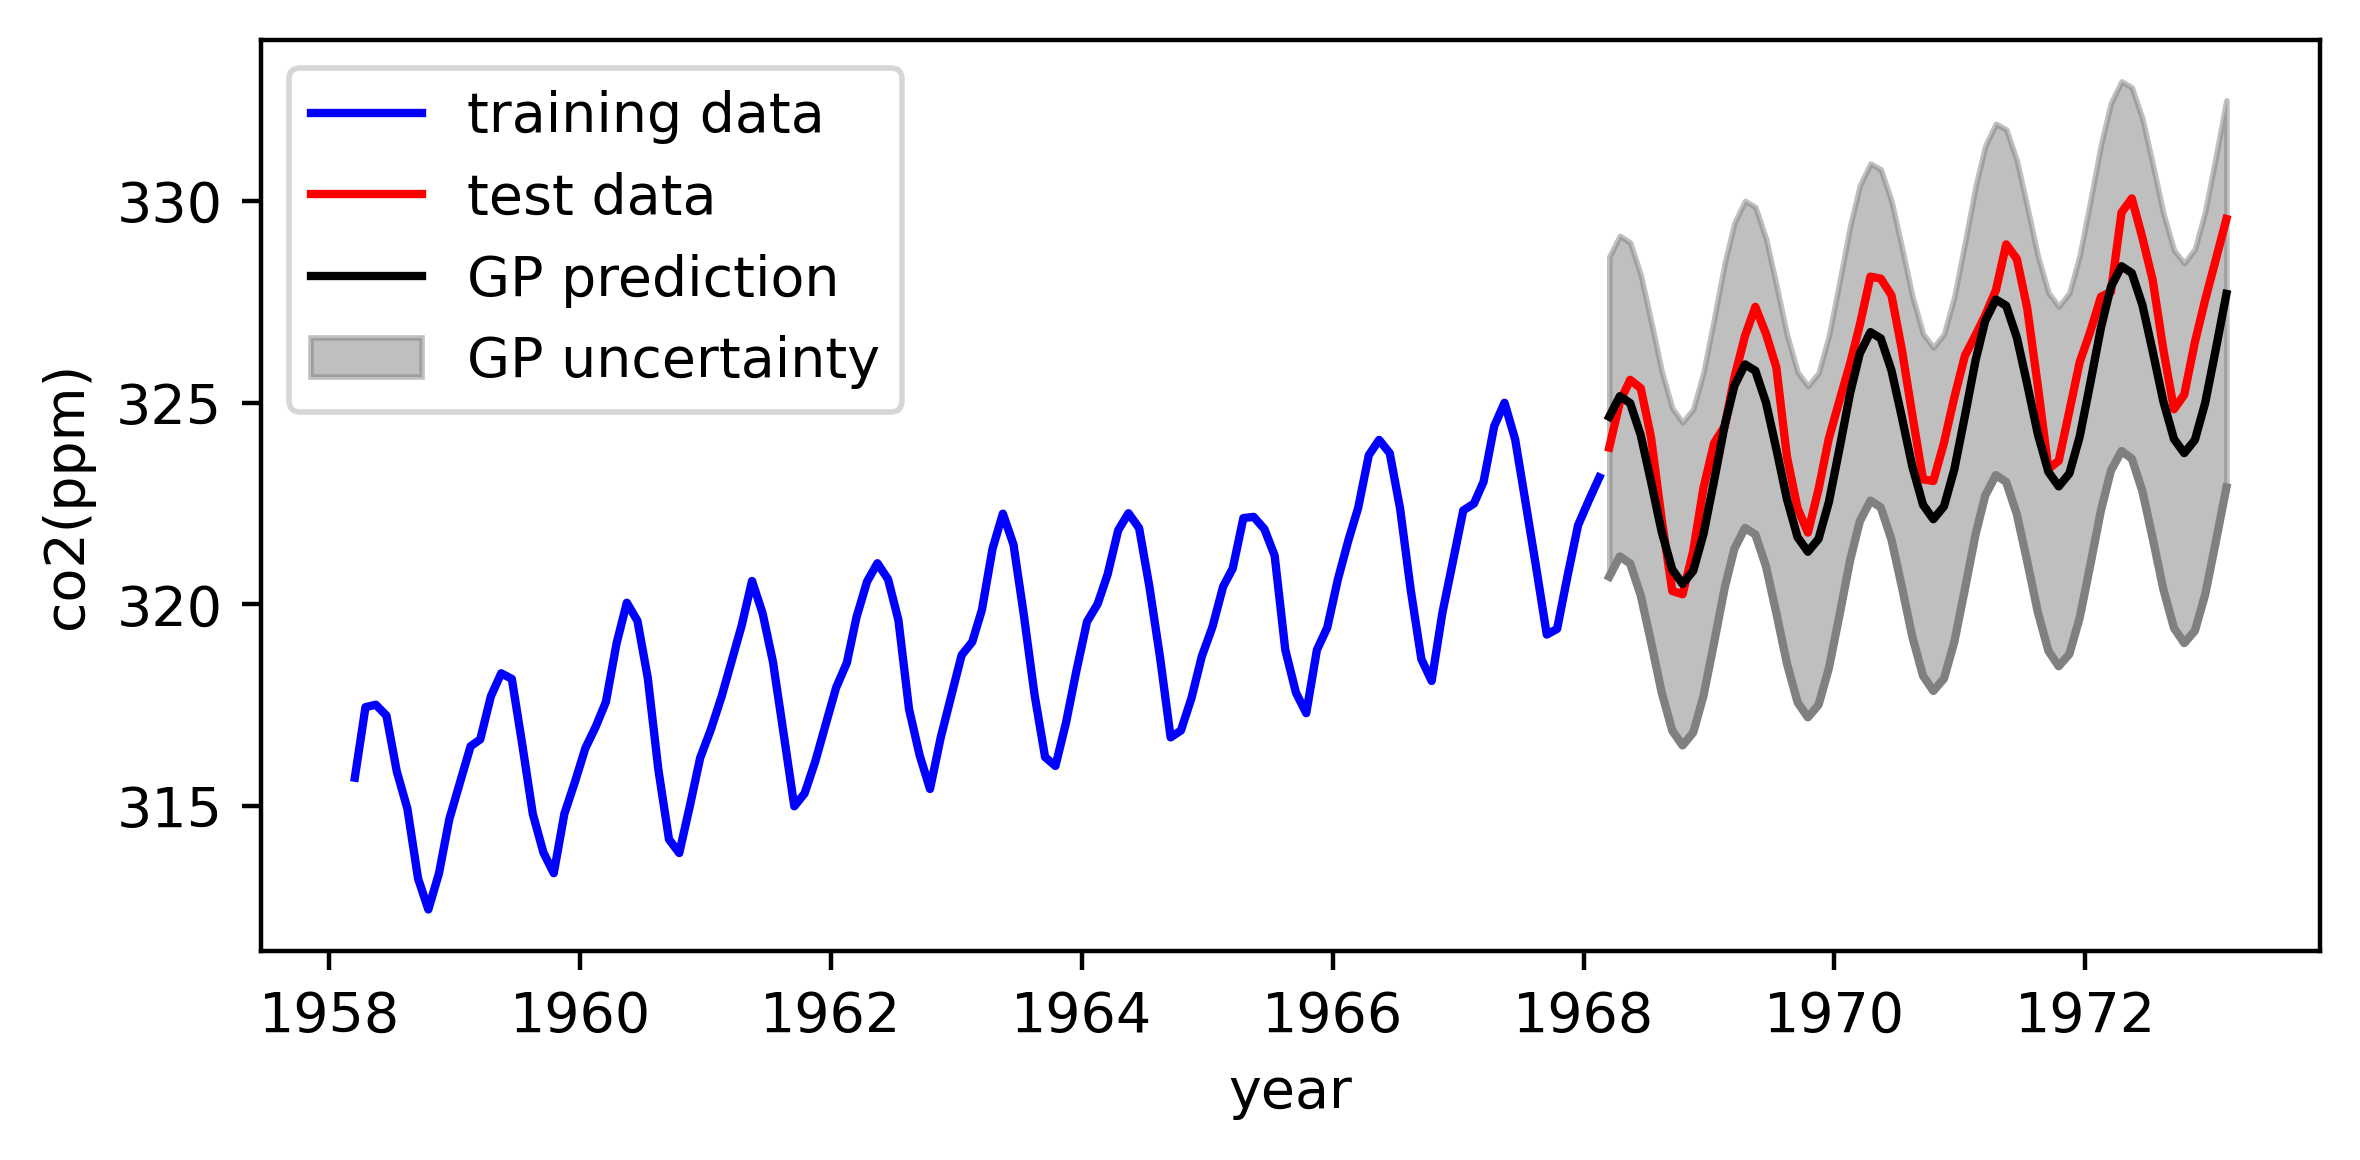

In [135]:
plt.figure(dpi=400, figsize=(6, 3))
plt.plot(X + 1958, y_raw, color="blue", label="training data")
plt.plot(X_predict + 1958, y_predict, color="red", label="test data")
yout_m = prediction_mean_gp * y_std + y_mean
yout_v = var_gp * y_std**2
plt.plot(X_predict + 1958, yout_m, color="black", label="GP prediction")
# plt.plot(
#     X_predict + 1958, yout_m + 1.96 * yout_v**0.5, color="grey", label="GP uncertainty"
# )
plt.plot(X_predict + 1958, yout_m - 1.96 * yout_v**0.5, color="grey")
plt.fill_between(
    X_predict.reshape(-1) + 1958,
    yout_m - 1.96 * np.sqrt(yout_v),
    yout_m + 1.96 * np.sqrt(yout_v),
    color="grey",
    alpha=0.5,
    label="GP uncertainty",
)
plt.xlabel("year")
plt.ylabel("co2(ppm)")
plt.legend()
plt.tight_layout()